### Simple Poligeneration Stand Alone Model linopy 

In [69]:

import linopy
from linopy import Model
import pandas as pd
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Flow Diagram:
![Screenshot 2024-01-06 004016.png](<attachment:Screenshot 2024-01-06 004016.png>)
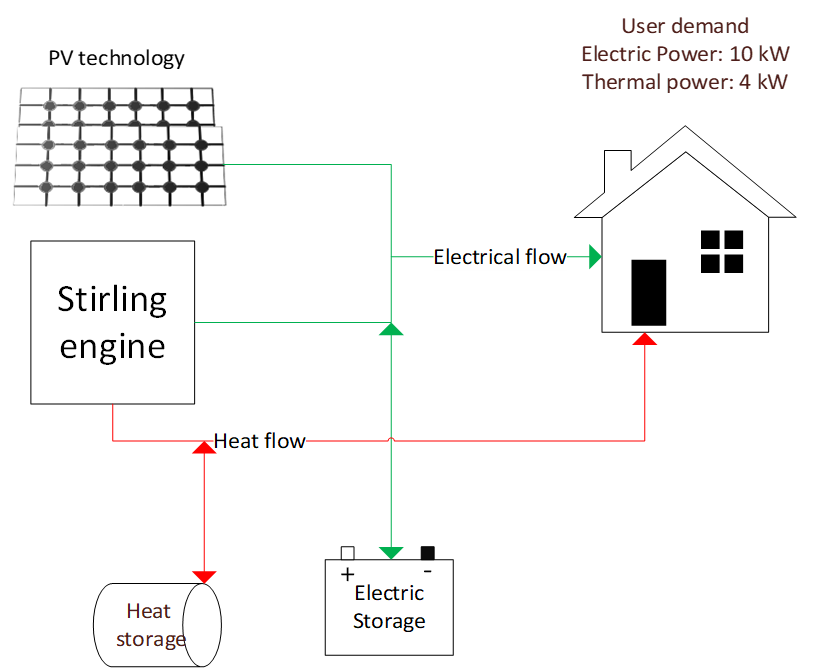

In [70]:
m = Model()
Sun = [0, 0, 0, 0, 0, 0.05, 0.2, 0.6, 0.8, 0.9, 0.95, 1, 1, 1, 0.95, 0.9, 0.8, 0.6, 0.2, 0, 0, 0, 0, 0]
"Home demand"
PowerDemand = [0.35, 0.35, 0.35, 0.35, 0.35, 0.56, 0.23, 0.23, 0.23, 0.23, 0.23,0.23, 0.23, 0.23, 0.23,0.23, 0.3, 0.6 , 0.6 , 1.73, 0.65, 0.65, 0.65, 0.35]
#PowerDemand = [10 for _ in range(24)]
#HeatDemand = [4 for _ in range(24)]
#HeatDemand = [4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,0,0,0, 0,0, 0, 4 , 4 , 4, 4, 4, 4, 4]
HeatDemand = [0 for _ in range(24)]
RHP = 2 #Heat to power ratio
Demand = pd.Index( ['PowerDemand','HeatDemand'], name = 'Demand')
#Demand = {"Demand": ['PowerDemand','HeatDemand']}
h = pd.Index(range(24), name = 'hours') #hours

#t = {"TECH": ["Sti", "PV", "ES", "HS"]}
tech = pd.Index( ["Sti", "PV", "ES", "HS"], name = 'tech')

### Parameters

In [71]:
capital_cost = xr.DataArray([1500, 2000, 65, 20], dims= 'tech', coords={'tech': tech}, name='Capital Costs')
fixedcost = xr.DataArray([0.015,  0.01, 0.05, 0.01], dims= 'tech', coords={'tech': tech}, name="fixed costs %")
AnnuF = xr.DataArray([0.13,  0.12, 0.40, 0.13], dims= 'tech', coords={'tech': tech}, name="Annualization Factor ")
variablecost =  xr.DataArray([0.2,  0.001, 0.001, 0.001], dims= 'tech', coords={'tech': tech}, name="variable cost $/kW") # including fuel cost and fuel consumption
# fuelcost = xr.DataArray([0.0475,  0, 0, 0], dims= 'tech', coords={'tech': tech}, name="fuel cost $/kWh")
storage_eficiency = xr.DataArray([0,  0, 0.65, 0.85], dims= 'tech', coords={'tech': tech}, name="storage eficiency")
chargefactor = xr.DataArray([0,  0, 0.9, 0.92],dims= 'tech', coords={'tech': tech}, name="charge factor")
recoverfactor = xr.DataArray([0,  0, 0.8, 0.9], dims= 'tech', coords={'tech': tech}, name="recovery factor")
AvailabilityFactor = xr.DataArray(np.ones((24, 4)), coords = [h, tech])
AvailabilityFactor[:,1] = Sun
Demands = xr.DataArray(np.column_stack((PowerDemand, HeatDemand)), coords=[h, Demand])

### Variables

In [72]:
power= m.add_variables(lower=0, coords=[tech[0:3], h] , name='Power Generation')
heat= m.add_variables(lower=0, coords=[tech[[0,3]], h] , name='Heat Generation')
capacity = m.add_variables(lower= 0 , coords= [tech], name = 'capacity')
ElectStorage = m.add_variables(lower=0, coords=[h], name = 'ElectStorage')
HeatStorage = m.add_variables(lower=0, coords=[h], name = 'HeatStorage')
Power2Storage = m.add_variables(lower=0, coords=[h], name = 'Power2Storage')
Heat2Storage = m.add_variables(lower=0, coords=[h], name = 'Heat2Storage')

In [73]:
index = pd.Index(['A', 'B', 'C', 'D', 'E'])
elements = index[index.get_indexer(['A', 'D'])]
print(elements)

Index(['A', 'D'], dtype='object')


### Objective Function

$$\sum_{i} C_{i} * CapCost_{Ci} *(AnnuF_{i} + FixCostOMF{i} )*\frac {nh}{8760}$$
$$+\sum_{i,t} PowerProd_{i,t}(FuelCostF_{i}+VarCostOM_{i}) \\ + HeatProd_{i,t} (FuelCostF_{i}+VarCostOM_{i})  $$



In [74]:

objective = (capital_cost*capacity*(AnnuF+fixedcost)*len(h)/8760).sum() + (power.loc[['Sti', 'PV', 'ES']]*variablecost.loc[['Sti', 'PV', 'ES']]).sum() + (heat.loc['HS']*variablecost.loc['HS']).sum()
m.add_objective(objective)



### Capacity Constraints
$ 
Power_{t,h}≤Capacity_{t}*AvailabilityFactor_{t,h}\\
$

In [75]:
power_capacity = m.add_constraints(power.loc[['Sti', 'PV'],h] <= capacity.loc[['Sti', 'PV']] * AvailabilityFactor.loc[h, ['Sti', 'PV']], name= 'power_capacity')
heat_storage_capacity = m.add_constraints(heat.loc[['HS'],h] <= capacity.loc[['HS']], name= 'heat_storage_capacity')

### Heat power ratio constraint

In [76]:
heat_power_ratio = m.add_constraints(heat.loc['Sti'] <= RHP * power.loc['Sti'], name='heat_power_ratio')

### Storage Constraints.
$ 
ES_t  = ES_{t-1}  + P2S_t*η -PS2/η  \\
ES_t ≤ Capacity[ES]    \\ 
ES_{24} = ES_1  \\
Power2Storage_t ≤ Cacacity[ES]*ChargeFactor[ES] \\
Power[ES]≤ Capacity[ES]*RecoverFactor[ES] \\
$
### Same Constraints for heat storage

In [77]:

"Electric Storage" 
m.add_constraints(ElectStorage.loc[0] == ElectStorage.loc[23] + Power2Storage.loc[0]*storage_eficiency.loc['ES']-power.loc['ES',0]/storage_eficiency.loc['ES'], name = 'SEq1')
m.add_constraints(ElectStorage.loc[1:len(h)-1] == ElectStorage.loc[0:len(h)-2] + Power2Storage.loc[1:len(h)-1]*storage_eficiency.loc['ES']-power.loc['ES',1:len(h)-1]/storage_eficiency.loc['ES'], name = 'SEq2')
m.add_constraints(Power2Storage <= capacity.loc['ES']*chargefactor.loc['ES'] , name = 'SEq3')
m.add_constraints(power.loc['ES'] <= capacity.loc['ES']*recoverfactor.loc['ES'] , name = 'SEq4')
m.add_constraints(ElectStorage <=capacity.loc['ES'], name = 'Estorage_capacity')
#######################################################################################
##### Future work implement shift function. ElectStorage - ElectStorage.shift(hours=1) 
####ElectStorage == ElectStorage.shift(hours = 1) + Power2Storage*storage_eficiency.loc['ES']-power.loc['ES']/storage_eficiency.loc['ES'] Similar, but still not the same.
"Heat Storage"
m.add_constraints(HeatStorage.loc[0] == HeatStorage.loc[23] + Heat2Storage.loc[0]*storage_eficiency.loc['HS']-heat.loc['HS',0]/storage_eficiency.loc['HS'], name = 'SEq5')
m.add_constraints(HeatStorage.loc[1:len(h)-1] == HeatStorage.loc[0:len(h)-2] + Heat2Storage.loc[1:len(h)-1]*storage_eficiency.loc['HS']-heat.loc['HS',1:len(h)-1]/storage_eficiency.loc['HS'], name = 'SEq6')
m.add_constraints(Heat2Storage <= capacity.loc['HS']*chargefactor.loc['HS'], name = 'SEq7')
m.add_constraints(heat.loc['HS'] <= capacity.loc['HS']*recoverfactor.loc['HS'], name = 'SEq8')
m.add_constraints(HeatStorage <=capacity.loc['HS'], name = 'Hstorage_capacity')

"Crear restricciones de almacenamiento con condicionales"
# for hours in h:
#     if hours == 0:
#         m.add_constraints(ElectStorage.loc[0] == ElectStorage.loc[23]+ Power2Storage.loc[0]*storage_eficiency.loc['ES']-power.loc['ES',0]/storage_eficiency.loc['ES'], name = 'SEq1')
#         m.add_constraints(HeatStorage.loc[0] == HeatStorage.loc[23] + Heat2Storage.loc[0]*storage_eficiency.loc['HS']-heat.loc['HS',0]/storage_eficiency.loc['HS'], name = 'SEq5')
#     else:
#         m.add_constraints(ElectStorage.loc[hours] == ElectStorage.loc[hours-1] + Power2Storage.loc[hours]*storage_eficiency.loc['ES']-power.loc['ES',hours]/storage_eficiency.loc['ES'])
#         m.add_constraints(HeatStorage.loc[hours] == HeatStorage.loc[hours-1] + Heat2Storage.loc[hours]*storage_eficiency.loc['HS']-heat.loc['HS',hours]/storage_eficiency.loc['HS'])

'Crear restricciones de almacenamiento con condicionales'

### Energy Balance

In [78]:

pdem = m.add_constraints(power.loc['Sti'] + power.loc['PV'] + power.loc['ES'] - Power2Storage >= Demands.loc [h,'PowerDemand'], name = 'pdem')
hdem = m.add_constraints(heat.loc['Sti'] + heat.loc['HS'] - Heat2Storage >= Demands.loc [h,'HeatDemand'], name = 'hdem')


In [79]:
m.solve("highs")
#pd.DataFrame(power.solutions = tech).transpose()

('ok', 'optimal')

In [80]:
pd.DataFrame(capacity.solution, index = tech).T

tech,Sti,PV,ES,HS
0,0.35,0.932941,3.856561,0.0


In [81]:
pd.DataFrame(power.solution, index=tech[0:3]).T

tech,Sti,PV,ES
0,0.350000,-0.000000,-0.000000
1,0.350000,-0.000000,0.000000
2,0.350000,-0.000000,-0.000000
3,0.350000,-0.000000,-0.000000
4,0.350000,-0.000000,-0.000000
5,0.350000,0.046647,0.163353
6,0.043412,0.186588,-0.000000
7,-0.000000,0.559764,0.000000
8,-0.000000,0.746352,0.000000
9,-0.000000,0.839647,0.000000


In [82]:
Heat2Storage.solution

<xarray.DataArray 'solution' (hours: 24)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * hours    (hours) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [83]:
pd.DataFrame(heat.solution).T

,0,1
0,0.700000,0.0
1,0.700000,0.0
2,0.700000,0.0
3,0.700000,0.0
4,0.700000,0.0
5,0.700000,0.0
6,0.086824,0.0
7,0.000000,0.0
8,0.000000,0.0
9,0.000000,0.0


In [84]:
for i in m.constraints:
    print(i)
    #m.constraints.{i}.print

power_capacity
heat_storage_capacity
heat_power_ratio
SEq1
SEq2
SEq3
SEq4
Estorage_capacity
SEq5
SEq6
SEq7
SEq8
Hstorage_capacity
pdem
hdem


In [85]:
for constraint_name in m.constraints:
    constraint = m.constraints[constraint_name]
    constraint.print(200)

Constraint `power_capacity` (tech: 2, hours: 24):
-------------------------------------------------
[Sti, 0]: +1 Power Generation[Sti, 0] - 1 capacity[Sti]   ≤ -0.0
[Sti, 1]: +1 Power Generation[Sti, 1] - 1 capacity[Sti]   ≤ -0.0
[Sti, 2]: +1 Power Generation[Sti, 2] - 1 capacity[Sti]   ≤ -0.0
[Sti, 3]: +1 Power Generation[Sti, 3] - 1 capacity[Sti]   ≤ -0.0
[Sti, 4]: +1 Power Generation[Sti, 4] - 1 capacity[Sti]   ≤ -0.0
[Sti, 5]: +1 Power Generation[Sti, 5] - 1 capacity[Sti]   ≤ -0.0
[Sti, 6]: +1 Power Generation[Sti, 6] - 1 capacity[Sti]   ≤ -0.0
[Sti, 7]: +1 Power Generation[Sti, 7] - 1 capacity[Sti]   ≤ -0.0
[Sti, 8]: +1 Power Generation[Sti, 8] - 1 capacity[Sti]   ≤ -0.0
[Sti, 9]: +1 Power Generation[Sti, 9] - 1 capacity[Sti]   ≤ -0.0
[Sti, 10]: +1 Power Generation[Sti, 10] - 1 capacity[Sti] ≤ -0.0
[Sti, 11]: +1 Power Generation[Sti, 11] - 1 capacity[Sti] ≤ -0.0
[Sti, 12]: +1 Power Generation[Sti, 12] - 1 capacity[Sti] ≤ -0.0
[Sti, 13]: +1 Power Generation[Sti, 13] - 1 capacity[St

: 